### sampler testing

Build a 2D sampler that samples from the data with the labels in a fixed amount of the time, and then from the whole dataset the rest of the time.

In [2]:
"""
The way that I think I should go about doing this, is the following:


create two samplers: 
a first one that samples just for the target class instances. Nice.
another one that just randomly samples from any elements in the dataset (a shuffle dataset), but excludes examples sampled in the first sampler
"""

'\nThe way that I think I should go about doing this, is the following:\n\n\ncreate two samplers: \na first one that samples just for the target class instances. Nice.\nanother one that just randomly samples from any elements in the dataset (a shuffle dataset), but excludes examples sampled in the first sampler\n'

In [6]:
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [7]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"

In [9]:
train_ds, val_ds = train_data_pipeline(collated_folder, val_proportion=0.15, seed=5, transforms=None)

In [85]:
import torch
from torch.utils.data import Sampler
import numpy as np
import matplotlib.pyplot as plt

In [109]:
class BinaryTargetClassBatchSampler(Sampler):
    def __init__(self, dataset, target_class, target_class_proportion, batch_size):
        self.dataset = dataset
        self.target_class = target_class
        self.batch_size = batch_size
        assert 0 <= target_class_proportion <= 1
        self.targets_per_batch = max(int(np.round(target_class_proportion * batch_size)), 1)
        self.remaining_per_batch = batch_size - self.targets_per_batch

        # record the indices of instances containing the target class
        self.target_indices = [
            i for i, data in enumerate(self.dataset)
            if (data['label'] == target_class).max() > 0
        ]
        self.all_indices = torch.arange(0, len(dataset), 1).tolist()

        print(len(self.target_indices))

    def __iter__(self):
        while True:
            # shuffle the target indices
            target_indices = torch.randperm(len(self.target_indices)).tolist()

            # sample the required number of target indices without replacement
            target_batch = target_indices[:self.targets_per_batch]

            # remove the selected target indices from the all_indices vector
            remaining_indices = list(set(self.all_indices) - set(target_batch))
            np.random.shuffle(remaining_indices)

            # select the required number of remaining indices to fill the batch, without replacement
            remaining_batch = remaining_indices[:self.remaining_per_batch]

            # construct the batch such that target and remaining examples are randomly shuffled together
            batch = target_batch + remaining_batch
            random_indices = torch.randperm(len(batch)).tolist()
            batch = [batch[i] for i in random_indices]

            yield batch
            

    def __len__(self):
        return len(self.dataset)

In [147]:
sampler = BinaryTargetClassBatchSampler(train_ds, 1, 0.33, 32)

1153


The sampler is working as intended. We can set this threshold as a parameter for our data and see how it affects performance.
One thing worthy of note, even with we set it to 0.33, which is less than the proportion of data that does contain some WMH, we still get a bimodal distribution with those indices being more likely, which of course makes sense because they are still more likely to be pixed.
When we set the threshold very high, near 1, there are some examples that will never get picked which is not necessearily what we want. When we compute over the whole training time (250*1000) we see that everything gets sampled and the min max range is good, there aren't examples that
never get selected for. We can compare training with this to training with just a normal batch shuffler in 2D.
I have not thought about the 3D implementation. Nice.

In [148]:
print(len(train_ds))

2171


In [149]:
count = 0
used = [0 for _ in range(len(train_ds))]
for indices in sampler:
    count += 1
    for idx in indices:
        used[idx] += 1
    if count == 250 * 10:#* 1000: # len(train_ds) // 32:
        break

In [150]:
max(used), min(used)

(70, 10)

<BarContainer object of 71 artists>

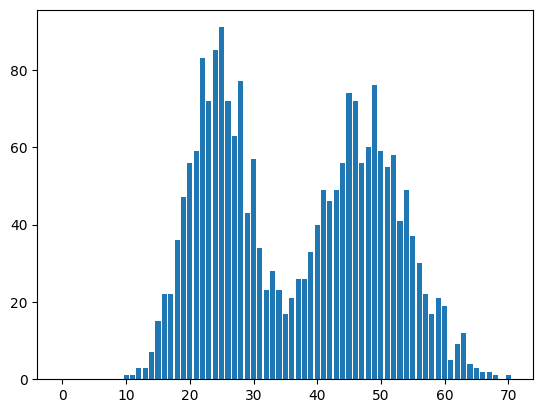

In [151]:
x = np.arange(0, max(used) + 1, 1)
used = torch.Tensor(used)
height = [(used == u).sum() for u in x]
plt.bar(x, height)

In [92]:
height

[tensor(849),
 tensor(761),
 tensor(386),
 tensor(112),
 tensor(46),
 tensor(13),
 tensor(2),
 tensor(2)]

In [93]:
386 + 112 * 2 + 46 * 3 + 13 * 4 + 2 * 5 + 2 * 5

820

In [95]:
len(train_ds) / 32

67.84375

In [97]:
len(train_ds) * 0.0084375

18.317812500000002